In [1]:
import autograd
from autograd import numpy as np
from autograd import scipy as sp

import scipy as osp

from numpy.polynomial.hermite import hermgauss

np.random.seed(453453)

import paragami

# BNP sensitivity libraries
import sys

import bnpgmm_runjingdev.gmm_clustering_lib as gmm_lib
import bnpgmm_runjingdev.utils_lib as utils_lib
import bnpgmm_runjingdev.gmm_cavi_lib as cavi_lib
import bnpgmm_runjingdev.gmm_preconditioner_lib as preconditioner_lib

import bnpmodeling_runjingdev.modeling_lib as modeling_lib 
import bnpmodeling_runjingdev.cluster_quantities_lib as cluster_lib
import bnpmodeling_runjingdev.optimization_lib as optimization_lib


import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm

from sklearn.decomposition import PCA

from copy import deepcopy

import vittles

import time 

import json 

import scipy as osp

/home/rliu/anaconda3/envs/bnp_sensitivity/lib/python3.8/site-packages/autograd/core.py:290: UserWarning: 
The defvjp method is deprecated. See the update guide and tutorial:
https://github.com/HIPS/autograd/blob/master/docs/updateguide.md
https://github.com/HIPS/autograd/blob/master/docs/tutorial.md
  warnings.warn(deprecation_msg)


In [2]:
np.random.seed(53453)

# Load data

In [3]:
# load iris data
dataset_name = 'iris'
features, iris_species = utils_lib.load_data()
dim = features.shape[1]
n_obs = len(iris_species)    

Text(0, 0.5, 'PC2')

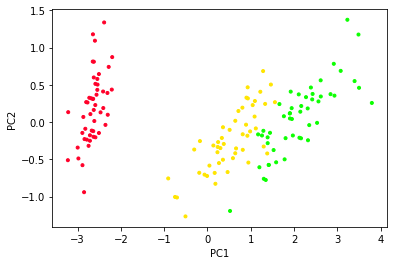

In [4]:
# run PCA
pca_fit = PCA()
pca_fit.fit(features)
pc_features = pca_fit.transform(features)

# plot
cmap = cm.get_cmap(name='gist_rainbow')
colors1 = [cmap(k * 50) for k in range(30)]

fig1 = plt.figure(1)
fig = fig1.add_subplot(111)
utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], iris_species, colors1, fig)
fig.set_xlabel('PC1')
fig.set_ylabel('PC2')


# Get prior

In [5]:
prior_params_dict, prior_params_paragami = gmm_lib.get_default_prior_params(dim)
prior_params_dict['alpha'] = np.array([3.0])
print(prior_params_dict)

prior_params_free = prior_params_paragami.flatten(prior_params_dict, free = True)

{'alpha': array([3.]), 'prior_centroid_mean': array([0.]), 'prior_lambda': array([1.]), 'prior_wishart_df': array([10.]), 'prior_wishart_rate': array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])}


# Get VB params 

In [6]:
k_approx = 30

In [7]:
gh_deg = 8
gh_loc, gh_weights = hermgauss(gh_deg)

In [8]:
# get vb parameters
vb_params_dict, vb_params_paragami = gmm_lib.get_vb_params_paragami_object(dim, k_approx)

In [9]:
# the objective 
gmm_lib.get_kl(features, vb_params_dict, prior_params_dict, gh_loc, gh_weights)

1459.0115663552124

## Initialize 

In [10]:
# run a kmeans init
n_kmeans_init = 10
init_vb_free_params, init_vb_params_dict, init_ez = \
    utils_lib.cluster_and_get_k_means_inits(features, vb_params_paragami, 
                                                n_kmeans_init = n_kmeans_init, 
                                                seed = 3445)
                                                
print('initial kl: ')
print(gmm_lib.get_kl(features, init_vb_params_dict, prior_params_dict, gh_loc, gh_weights))

initial kl: 
6580.095037059639


In [11]:
def plot_results_from_vb_params_dict(pca_fit, vb_params_dict, e_z, fig): 
    # we plot in PCA space
    bnp_centroids_pc, bnp_cluster_covs_pc = \
        utils_lib.transform_params_to_pc_space(pca_fit, vb_params_dict['cluster_params']['centroids'], 
                                               np.linalg.inv(vb_params_dict['cluster_params']['cluster_info']))
    
    bnp_clusters = np.argmax(e_z, axis = 1)
    
    cmap = cm.get_cmap(name='gist_rainbow')
    colors1 = [cmap(k * 50) for k in range(30)]

    utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], bnp_clusters, \
                  colors1, fig, \
                  centroids = bnp_centroids_pc[:, np.unique(bnp_clusters)], 
                cov = bnp_cluster_covs_pc[np.unique(bnp_clusters)])


Text(0, 0.5, 'PC2')

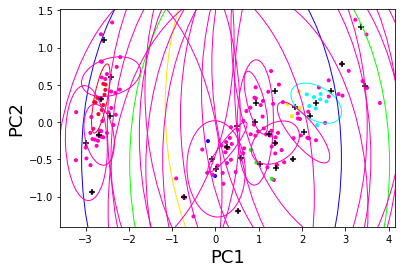

In [12]:
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

plot_results_from_vb_params_dict(pca_fit, init_vb_params_dict, init_ez, fig)
fig.set_xlabel('PC1', fontsize = 18)
fig.set_ylabel('PC2', fontsize = 18)


# Run CAVI

In [13]:
vb_opt_dict, e_z_cavi = cavi_lib.run_cavi(features, vb_params_dict,
                                            vb_params_paragami, prior_params_dict,
                                            gh_loc, gh_weights,
                                            debug = False)

done. num iterations = 266
stick_time: 1.378sec
cluster_time: 0.125sec
e_z_time: 0.349sec
**TOTAL time: 4.205sec**


In [14]:
vb_opt = vb_params_paragami.flatten(vb_opt_dict, free = True)

# Define objective

In [15]:
# get loss as a function of vb parameters
get_vb_params_loss = paragami.FlattenFunctionInput(
                                original_fun=gmm_lib.get_kl, 
                                patterns = [vb_params_paragami, prior_params_paragami],
                                free = True,
                                argnums = [1, 2])

objective_fun = lambda x, y : get_vb_params_loss(features, x, y, gh_loc, gh_weights)


In [16]:
# get derivative functions
obj_fun_grad = autograd.grad(objective_fun, argnum=0)
obj_fun_hessian = autograd.hessian(objective_fun, argnum=0)
obj_fun_hvp = autograd.hessian_vector_product(
            objective_fun, argnum=0)

# Derivative times

In [17]:
t0 = time.time()
loss = objective_fun(vb_opt, prior_params_free)
print('function time: {:0.3}sec'.format(time.time() - t0))

function time: 0.0156sec


In [18]:
t0 = time.time()
grad = obj_fun_grad(vb_opt, prior_params_free)
print('gradient time: {:0.3}sec'.format(time.time() - t0))

gradient time: 0.039sec


In [19]:
# if its impossible, don't run the hessian
run_hessian = True

In [20]:
if run_hessian: 
    t0 = time.time()
    hess = obj_fun_hessian(vb_opt, prior_params_free)
    print('hessian time: {:0.3}sec'.format(time.time() - t0))

hessian time: 13.7sec


In [21]:
t0 = time.time()

x = np.zeros(len(vb_opt))# vb_opt
x[0] = 1
hvp = obj_fun_hvp(vb_opt, prior_params_free, x)
print('hvp time: {:0.3}sec'.format(time.time() - t0))

hvp time: 0.168sec


In [22]:
# cross hessian 
hyper_obj_fun_grad = \
            autograd.grad(objective_fun, argnum=0)
hyper_obj_cross_hess = autograd.jacobian(hyper_obj_fun_grad, argnum=1)

In [23]:
t0 = time.time()
cross_hess = hyper_obj_cross_hess(vb_opt, prior_params_free)
print('cross-hessian time: {:0.3}sec'.format(time.time() - t0))

cross-hessian time: 3.34sec


# Solver times

In [24]:
if run_hessian: 
    chol_solver = vittles.solver_lib.get_cholesky_solver(hess)
    
    t0 = time.time()
    dinput_dhyper = -chol_solver(cross_hess)
    
    print('solver time: {:0.3}sec'.format(time.time() - t0))

solver time: 0.00121sec


In [25]:
cg_solver = vittles.solver_lib.get_cg_solver(lambda x : obj_fun_hvp(vb_opt, prior_params_free, x), 
                                            dim = len(vb_opt))
    
t0 = time.time()
dinput_dhyper2 = -cg_solver(cross_hess[:, 0])
    
print('solver time: {:0.3}sec'.format(time.time() - t0))

solver time: 9.66sec


In [26]:
mfvb_preconditioner = preconditioner_lib.get_gmm_preconditioner(vb_opt, vb_params_paragami)

In [27]:
cg_solver_mfvb_precond = vittles.solver_lib.get_cg_solver(lambda x : obj_fun_hvp(vb_opt, prior_params_free, x), 
                                            dim = len(vb_opt), 
                                            cg_opts={'M':mfvb_preconditioner})
    
t0 = time.time()
dinput_dhyper3 = -cg_solver_mfvb_precond(cross_hess[:, 0])
    
print('preconditioned solver time: {:0.3}sec'.format(time.time() - t0))

preconditioned solver time: 6.48sec


# Lets look at the CG solver in more detail 

### Check out eigenvalues

In [28]:
hess_ev = np.linalg.eigvals(hess)

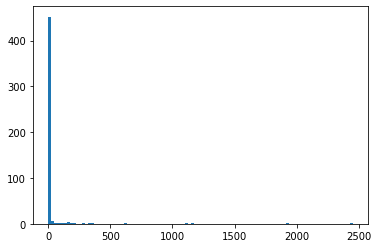

In [29]:
plt.hist(hess_ev - hess_ev.min(), bins = 100);

In [30]:
precond_sqrt = osp.linalg.sqrtm(mfvb_preconditioner.toarray())
np.abs(precond_sqrt - precond_sqrt.transpose()).max()

3.567538391042636e-14

/home/rliu/anaconda3/envs/bnp_sensitivity/lib/python3.8/site-packages/numpy/lib/histograms.py:854: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/home/rliu/anaconda3/envs/bnp_sensitivity/lib/python3.8/site-packages/matplotlib/transforms.py:796: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)
/home/rliu/anaconda3/envs/bnp_sensitivity/lib/python3.8/site-packages/matplotlib/transforms.py:1959: ComplexWarning: Casting complex values to real discards the imaginary part
  x, y = float(x), float(y)


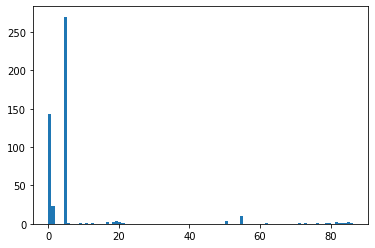

In [31]:
precond_hess = np.dot(precond_sqrt, np.dot(hess, precond_sqrt))
precon_hess_ev = np.linalg.eigvals(precond_hess)
plt.hist(precon_hess_ev - precon_hess_ev.min(), bins = 100);

In [32]:
dim = len(vb_opt)
mat_times_vec = lambda x : obj_fun_hvp(vb_opt, prior_params_free, x)
linop = osp.sparse.linalg.LinearOperator((dim, dim), mat_times_vec)

b = cross_hess[:, 0]

### Check out optimization path

In [33]:
class CGCallback(): 
    def __init__(self, mat_times_vec, b): 
        self.mat_times_vec = mat_times_vec
        self.b = b
        
        self.residuals = []
        
    def record_residuals(self, x): 
#         e_z = gmm_lib.get_optimal_z_from_vb_params_dict(features, 
#                                        vb_params_paragami.fold(x, free = True), 
#                                        gh_loc, gh_weights)
        
#         e_num_clust = cluster_lib.get_e_num_clusters_from_ez(e_z)
        
#         self.residuals.append(e_num_clust)
        
#         self.residuals.append(np.linalg.norm(b - self.mat_times_vec(x)))

        self.residuals.append(np.linalg.norm(-x - dinput_dhyper[:, 0]))
        
    def return_path(self): 
        return np.array(self.residuals)

In [34]:
mat_times_vec = lambda x : obj_fun_hvp(vb_opt, prior_params_free, x)
b = cross_hess[:, 0]
cg_callback = CGCallback(mat_times_vec, b)

x0 = mfvb_preconditioner.dot(b)

In [35]:
cg_callback = CGCallback(mat_times_vec, b)
solver = vittles.solver_lib.get_cg_solver(mat_times_vec, 
                                            dim = len(vb_opt), 
                                            cg_opts={'callback':cg_callback.record_residuals, 
                                                    'x0':x0})
    
t0 = time.time()
_ = -solver(b)
print('solver time: {:0.3}sec'.format(time.time() - t0))
path1 = cg_callback.return_path()

solver time: 11.7sec


In [36]:
cg_callback = CGCallback(mat_times_vec, b)
solver = vittles.solver_lib.get_cg_solver(mat_times_vec, 
                                            dim = len(vb_opt), 
                                            cg_opts={'M':mfvb_preconditioner, 
                                                     'callback':cg_callback.record_residuals, 
                                                    'x0':x0})
    
t0 = time.time()
_ = -solver(b)
print('solver time: {:0.3}sec'.format(time.time() - t0))
path2 = cg_callback.return_path()

solver time: 4.14sec


Text(0, 0.5, 'log10 residual')

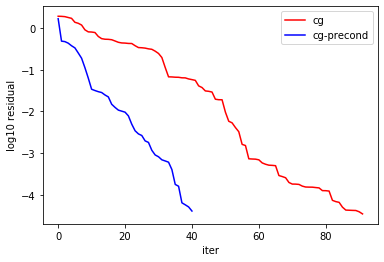

In [37]:
plt.plot(np.log10(path1), color = 'red', label = 'cg')
plt.plot(np.log10(path2), color = 'blue', label = 'cg-precond')
plt.legend()

plt.xlabel('iter')
plt.ylabel('log10 residual')

# Try nystrom

In [38]:
def taylor_expand_matrix_inverse(mat_vec, v, max_eval, max_iter):
    
    t_power = deepcopy(v)
    x_inv_v = deepcopy(v)
    
    for i in range(max_iter): 
        t_power = t_power - mat_vec(t_power) / (max_eval + 1)
        x_inv_v += t_power
    
    return x_inv_v / (max_eval + 1)

In [39]:
# a quick test 
dim = 3
_a = np.random.randn(dim, dim)
a = np.dot(_a, _a.transpose())

mat_vec = lambda x: np.dot(a, x)

max_eval = np.linalg.eigvals(a).max()

v = np.random.randn(dim)

foo = taylor_expand_matrix_inverse(mat_vec, v, max_eval, max_iter = 1000)

true = np.linalg.solve(a, v)

print(foo / true)

[0.99998116 0.99998158 0.99998168]


In [40]:
def get_nystrom_woodbury_approx(A, indx): 
    C = A[:, indx]
    W_inv = np.linalg.inv(A[indx][:, indx])
    
    inv_term = np.linalg.inv(np.eye(C.shape[1]) - np.dot(W_inv, np.dot(C.transpose(), C)))
    
    woodb_inv = np.eye(C.shape[0]) + np.dot(np.dot(C, inv_term), np.dot(W_inv, C.transpose()))
    
    return woodb_inv, C, W_inv

In [41]:
# another quick test 
a = np.random.randn(3, 3)
A = np.eye(3) + np.dot(a, a.transpose())

woodb_inv, C, W_inv = get_nystrom_woodbury_approx(A, indx = np.array([0, 1]))

A_tilde = np.dot(np.dot(C, W_inv), C.transpose())

np.abs(np.linalg.inv(np.eye(3) - A_tilde) - woodb_inv).max()

4.440892098500626e-16

## Get large clusters

In [58]:
e_z_opt = gmm_lib.get_optimal_z_from_vb_params_dict(features, 
                                       vb_params_paragami.fold(vb_opt, free = True), 
                                       gh_loc, gh_weights)

In [59]:
k_large = 5
which_k = np.argsort(-e_z_opt.mean(0))[0:k_large]

In [60]:
which_k

array([2, 4, 0, 1, 3])

In [61]:
import bnpmodeling_runjingdev.modeling_lib as modeling_lib
log_probs = modeling_lib.get_e_log_cluster_probabilities(vb_params_dict['stick_params']['stick_propn_mean'],
                                            vb_params_dict['stick_params']['stick_propn_info'], 
                                            gh_loc, gh_weights)
np.argsort(-log_probs)[0:k_large]

array([2, 4, 0, 1, 3])

In [62]:
bool_dict = vb_params_paragami.empty_bool(False)
bool_dict['cluster_params']['centroids'][:, which_k] = True
bool_dict['cluster_params']['cluster_info'][which_k] = True

_which_k = which_k
_which_k = _which_k[_which_k != (k_approx - 1)]
bool_dict['stick_params']['stick_propn_mean'][_which_k] = True
bool_dict['stick_params']['stick_propn_info'][_which_k] = True

In [63]:
indx = vb_params_paragami.flat_indices(bool_dict, free = True)

In [64]:
len(indx)

80

In [65]:
est_lambda_max = np.max(np.linalg.eigvals(hess)) 
# est_lambda_max = np.abs(hess).sum(0).max() * 100.

A = np.eye(hess.shape[0]) - hess / est_lambda_max

In [66]:
print('est lambda_max: ', est_lambda_max)
print('true lambda_max: ', np.max(np.linalg.eigvals(hess)))

est lambda_max:  2451.1259105527097
true lambda_max:  2451.1259105527097


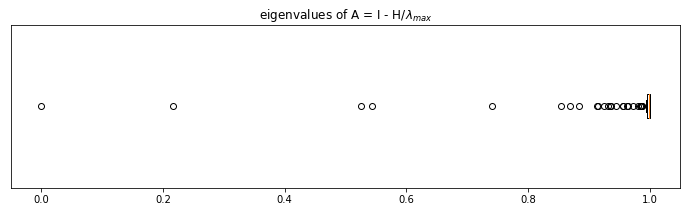

In [67]:
f, axarr = plt.subplots(1, 1, figsize=(12, 3))
axarr.boxplot(np.linalg.eigvals(A), vert=False);
axarr.set_yticks([]);
axarr.set_title('eigenvalues of A = I - H/$\lambda_{max}$'); 

In [68]:
# get woodbury-nystrom preconditioner
woodb_inv, C, W_inv = get_nystrom_woodbury_approx(A, indx)
nystrom_precond = woodb_inv/est_lambda_max

/home/rliu/anaconda3/envs/bnp_sensitivity/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


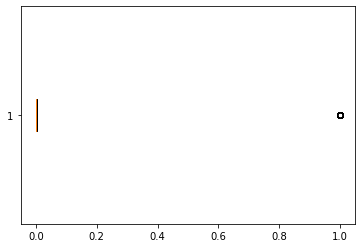

In [69]:
woodb_inv_sqrt = osp.linalg.sqrtm(woodb_inv)
m = np.dot(woodb_inv_sqrt, np.dot(np.eye(len(A)) - A, woodb_inv_sqrt))
plt.boxplot(np.linalg.eigvals(m), vert=False);
# plt.hist(np.linalg.eigvals(m))

In [70]:
precond_sqrt = osp.linalg.sqrtm(nystrom_precond)
precond_hess = np.dot(precond_sqrt, np.dot(hess, precond_sqrt))
evals = np.linalg.eigvals(precond_hess)
print(evals.max())
print(evals.max() / evals.min())

(1.0000007367698922-1.377410568111461e-17j)
(7523.440067052681-1.733777059761098e-12j)


/home/rliu/anaconda3/envs/bnp_sensitivity/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


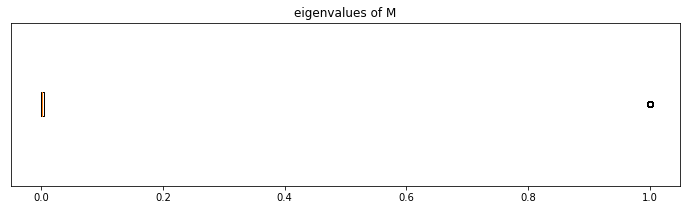

In [71]:
f, axarr = plt.subplots(1, 1, figsize=(12, 3))
axarr.boxplot(evals, vert=False);
axarr.set_yticks([]);
axarr.set_title('eigenvalues of M'); 

In [72]:
cg_callback = CGCallback(mat_times_vec, b)
solver = vittles.solver_lib.get_cg_solver(mat_times_vec, 
                                            dim = len(vb_opt), 
                                            cg_opts={'M':nystrom_precond, 
                                                     'callback':cg_callback.record_residuals, 
                                                    'x0':x0})
    
t0 = time.time()
_ = -solver(b)
print('solver time: {:0.3}sec'.format(time.time() - t0))
path3 = cg_callback.return_path()

solver time: 4.78sec


Text(0, 0.5, 'log10 residual')

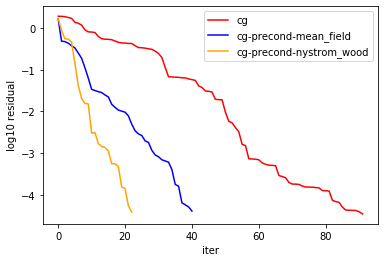

In [73]:
plt.plot(np.log10(path1), color = 'red', label = 'cg')
plt.plot(np.log10(path2), color = 'blue', label = 'cg-precond-mean_field')
plt.plot(np.log10(path3), color = 'orange', label = 'cg-precond-nystrom_wood')

plt.legend()

plt.xlabel('iter')
plt.ylabel('log10 residual')

# Crazy idea ... use only one block

In [74]:
bin_mat1 = np.zeros(hess.shape)
bin_mat1[indx] = 1.0

bin_mat2 = np.zeros(hess.shape)
bin_mat2[:, indx] = 1.0

bin_mat = bin_mat1 * bin_mat2

In [75]:
assert np.all(bin_mat[indx][:, indx] == 1)
assert np.all(bin_mat * (1 - bin_mat) == 0)

In [76]:
# set some blocks to zero
A2 = np.eye(hess.shape[0]) - hess * bin_mat / est_lambda_max

In [77]:
(hess - hess * bin_mat).max()

10.142413366623114

In [78]:
(hess - hess * (1 - bin_mat)).max()

1725.7477546185044

In [79]:
(A - A2).max()

0.0002355968833660157

In [80]:
# get woodbury-nystrom preconditioner
woodb_inv, C, W_inv = get_nystrom_woodbury_approx(A2, indx)
nystrom_precond2 = woodb_inv/est_lambda_max

In [81]:
np.abs(nystrom_precond2 - nystrom_precond).max()

0.07432392550546005

In [82]:
precond_sqrt = osp.linalg.sqrtm(nystrom_precond2)
precond_hess = np.dot(precond_sqrt, np.dot(hess, precond_sqrt))
evals = np.linalg.eigvals(precond_hess)
print(evals.min())
print(evals.max())

(0.00013289791134470083+0j)
(1.0000195307597624+0j)


/home/rliu/anaconda3/envs/bnp_sensitivity/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


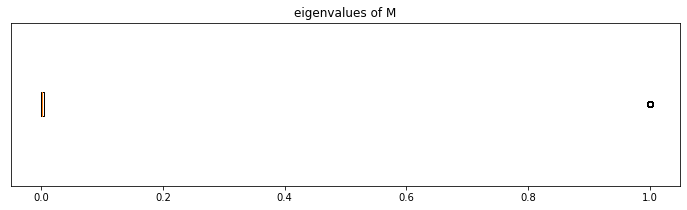

In [83]:
f, axarr = plt.subplots(1, 1, figsize=(12, 3))
axarr.boxplot(evals, vert=False);
axarr.set_yticks([]);
axarr.set_title('eigenvalues of M'); 

In [84]:
cg_callback = CGCallback(mat_times_vec, b)
solver = vittles.solver_lib.get_cg_solver(mat_times_vec, 
                                            dim = len(vb_opt), 
                                            cg_opts={'M':nystrom_precond2, 
                                                     'callback':cg_callback.record_residuals, 
                                                    'x0':x0})
    
t0 = time.time()
_ = -solver(b)
print('solver time: {:0.3}sec'.format(time.time() - t0))
path4 = cg_callback.return_path()

solver time: 4.26sec


Text(0, 0.5, 'log10 residual')

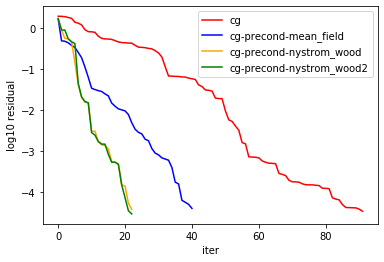

In [85]:
plt.plot(np.log10(path1), color = 'red', label = 'cg')
plt.plot(np.log10(path2), color = 'blue', label = 'cg-precond-mean_field')
plt.plot(np.log10(path3), color = 'orange', label = 'cg-precond-nystrom_wood')
plt.plot(np.log10(path4), color = 'green', label = 'cg-precond-nystrom_wood2')

plt.legend()

plt.xlabel('iter')
plt.ylabel('log10 residual')

# Can we try to estimate that upper block?

In [86]:
bool_dict = vb_params_paragami.empty_bool(False)
bool_dict['cluster_params']['centroids'][:, which_k] = True
bool_dict['cluster_params']['cluster_info'][which_k] = True

_which_k = which_k[:-1]
_which_k = _which_k[_which_k != (k_approx - 1)]
bool_dict['stick_params']['stick_propn_mean'][_which_k] = True
bool_dict['stick_params']['stick_propn_info'][_which_k] = True

In [87]:
indx2 = vb_params_paragami.flat_indices(bool_dict, free = True)

In [88]:
vb_params_dict = vb_params_paragami.fold(vb_opt, free = True)

In [89]:
# get vb parameters
sub_vb_params_dict, sub_vb_params_paragami = gmm_lib.get_vb_params_paragami_object(features.shape[1], k_large)

In [90]:
which_k_sorted = np.sort(which_k)
_which_k_sorted = np.sort(_which_k)

In [91]:
_which_k_sorted

array([0, 1, 2, 4])

In [92]:
sub_vb_params_dict['cluster_params']['centroids'] = \
    vb_params_dict['cluster_params']['centroids'][:, which_k_sorted]
sub_vb_params_dict['cluster_params']['cluster_info'] = \
    vb_params_dict['cluster_params']['cluster_info'][which_k_sorted]

sub_vb_params_dict['stick_params']['stick_propn_mean'] = \
    vb_params_dict['stick_params']['stick_propn_mean'][_which_k_sorted]
sub_vb_params_dict['stick_params']['stick_propn_info'] = \
    vb_params_dict['stick_params']['stick_propn_info'][_which_k_sorted]

In [93]:
sub_vb_params_free = sub_vb_params_paragami.flatten(sub_vb_params_dict, free = True)

In [94]:
np.abs(sub_vb_params_free - vb_opt[indx2]).max()

4.440892098500626e-16

In [95]:
# get loss as a function of vb parameters
get_vb_params_sub_loss = paragami.FlattenFunctionInput(
                                original_fun=gmm_lib.get_kl, 
                                patterns = [sub_vb_params_paragami, prior_params_paragami],
                                free = True,
                                argnums = [1, 2])

sub_objective_fun = lambda x, y : get_vb_params_sub_loss(features, x, y, gh_loc, gh_weights)

In [96]:
sub_obj_fun_hessian = autograd.hessian(sub_objective_fun, argnum=0)

In [97]:
sub_objective_fun(sub_vb_params_free, prior_params_free)

-126.66809229907517

In [98]:
objective_fun(vb_opt, prior_params_free)

-381.27894308780753

In [99]:
t0 = time.time()
sub_hess = sub_obj_fun_hessian(sub_vb_params_free, prior_params_free)
print('hessian time: {:0.3}sec'.format(time.time() - t0))

hessian time: 0.741sec


(array([ 2.,  0.,  0.,  1.,  2.,  0.,  0.,  3., 67.,  3.]),
 array([-213.92611336, -188.94519991, -163.96428645, -138.983373  ,
        -114.00245954,  -89.02154608,  -64.04063263,  -39.05971917,
         -14.07880572,   10.90210774,   35.8830212 ]),
 <a list of 10 Patch objects>)

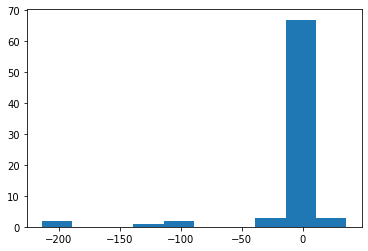

In [100]:
plt.hist(np.diag(sub_hess) - np.diag(hess)[indx2])

In [101]:
hess2 = np.zeros(hess.shape)

for i in range(len(sub_hess)): 
    for j in range(len(sub_hess)): 
        hess2[indx2[i], indx2[j]] = sub_hess[i, j]
        
assert (hess2[indx2][:, indx2] == sub_hess).all()

In [102]:
hess2

array([[1.00409814e+02, 9.86691047e-03, 2.21848046e+01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.86691047e-03, 5.21205159e+00, 3.84948233e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.21848046e+01, 3.84948233e-01, 5.41320932e+02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [103]:
hess * bin_mat

array([[ 1.00992997e+02,  1.42297253e-02,  2.46640109e+01, ...,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
       [ 1.42297253e-02,  5.35869545e+00,  5.52662266e-01, ...,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
       [ 2.46640109e+01,  5.52662266e-01,  6.41338859e+02, ...,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
       ...,
       [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
         0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
       [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
        -0.00000000e+00,  0.00000000e+00, -0.00000000e+00],
       [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
        -0.00000000e+00, -0.00000000e+00,  0.00000000e+00]])

In [147]:
from bnpgmm_runjingdev.gmm_clustering_lib import get_optimal_z

In [148]:
def get_loglik(y, vb_params_dict, use_bnp_prior = True, e_z = None): 
    stick_propn_mean = vb_params_dict['stick_params']['stick_propn_mean']
    stick_propn_info = vb_params_dict['stick_params']['stick_propn_info']
    centroids = vb_params_dict['cluster_params']['centroids']
    cluster_info = vb_params_dict['cluster_params']['cluster_info']

    # get optimal cluster belongings
    e_z_opt, loglik_obs_by_nk = \
            get_optimal_z(y, stick_propn_mean, stick_propn_info, centroids, cluster_info,
                            gh_loc, gh_weights, use_bnp_prior=use_bnp_prior)
    
    if e_z is None: 
        e_z = e_z_opt
    
    e_loglik_obs = np.sum((e_z * loglik_obs_by_nk))
    
    return e_loglik_obs, e_z_opt

In [149]:
sub_e_z_opt = get_loglik(features, sub_vb_params_dict, use_bnp_prior=False)[1]
e_z_opt = get_loglik(features, 
                        vb_params_paragami.fold(vb_opt, free = True), 
                        use_bnp_prior=False)[1]

In [150]:
_sub_e_z_opt = e_z_opt[:, which_k_sorted]

e_loglik_obs, _ = get_loglik(features, sub_vb_params_dict, use_bnp_prior=False, e_z = _sub_e_z_opt)
print(e_loglik_obs)

337.00827203796234


In [151]:
# _e_z = np.zeros(e_z_opt.shape)

# _e_z[:, which_k_sorted] = e_z_opt[:, which_k_sorted]

e_loglik_obs, _ = get_loglik(features, 
                               vb_params_paragami.fold(vb_opt, free = True), 
                              e_z = e_z_opt, 
                              use_bnp_prior=False)
print(e_loglik_obs)

375.21542504620356


In [152]:
sub_e_z_opt.argmax(1) - e_z_opt[:, which_k_sorted].argmax(1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

(array([90.,  8.,  3.,  4.,  1.,  8.,  8.,  9., 14.,  5.]),
 array([1.62092562e-14, 5.29000848e-02, 1.05800170e-01, 1.58700254e-01,
        2.11600339e-01, 2.64500424e-01, 3.17400509e-01, 3.70300593e-01,
        4.23200678e-01, 4.76100763e-01, 5.29000848e-01]),
 <a list of 10 Patch objects>)

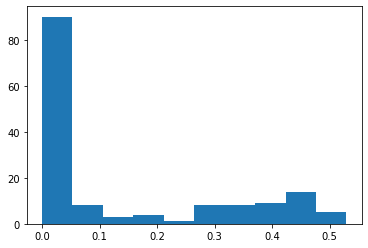

In [153]:
plt.hist(sub_e_z_opt.max(1) - e_z_opt[:, which_k_sorted].max(1))

In [154]:
np.argwhere(((sub_e_z_opt.max(1) - e_z_opt[:, which_k_sorted].max(1))) > 0.6)

array([], shape=(0, 1), dtype=int64)

In [155]:
sub_e_z_opt.shape

(150, 5)

In [156]:
# get loss as a function of vb parameters
sub_get_loglik_flat = paragami.FlattenFunctionInput(
                                original_fun=get_loglik, 
                                patterns = sub_vb_params_paragami,
                                free = True,
                                argnums = 1)

foo = lambda x : sub_get_loglik_flat(features, x, use_bnp_prior = False, e_z = _sub_e_z_opt)[0]
sub_loglik_grad = autograd.grad(foo)
sub_loglik_hess = autograd.hessian(foo)
grad_sll = sub_loglik_grad(sub_vb_params_paragami.flatten(sub_vb_params_dict, free = True))
hess_sll = sub_loglik_hess(sub_vb_params_paragami.flatten(sub_vb_params_dict, free = True))

In [157]:
# get loss as a function of vb parameters
get_loglik_flat = paragami.FlattenFunctionInput(
                                original_fun=get_loglik, 
                                patterns = vb_params_paragami,
                                free = True,
                                argnums = 1)

foo2 = lambda x : get_loglik_flat(features, x, use_bnp_prior = False, e_z = e_z_opt)[0]
loglik_grad = autograd.grad(foo2)
loglik_hess = autograd.hessian(foo2)
grad_ll = loglik_grad(vb_opt)
hess_ll = loglik_hess(vb_opt)

In [160]:
grad_sll - grad_ll[indx2]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  2.84217094e-14,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  2.27373675e-13,  0.00000000e+00,
        0.00000000e+00, -3.55271368e-14,  0.00000000e+00, -1.13686838e-13,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -2.22044605e-16,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -1.15463195e-14, -4.44089210e-15, -5.32907052e-15,  7.99360578e-15,
        7.10542736e-15, -5.32907052e-15,  8.65973959e-15, -8.88178420e-16,
       -1.42108547e-14,  1.95399252e-14,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

(array([ 1.,  0.,  0.,  4., 69.,  0.,  2.,  0.,  0.,  2.]),
 array([-1.13686838e-13, -8.52651283e-14, -5.68434189e-14, -2.84217094e-14,
         0.00000000e+00,  2.84217094e-14,  5.68434189e-14,  8.52651283e-14,
         1.13686838e-13,  1.42108547e-13,  1.70530257e-13]),
 <a list of 10 Patch objects>)

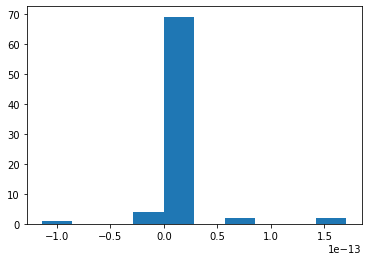

In [161]:
plt.hist(np.diag(hess_ll[indx2][:, indx2]) - np.diag(hess_sll))

In [162]:
np.abs((hess_ll[indx2][:, indx2] - hess_sll)).max()

2.2737367544323206e-13

In [163]:
sub_vb_params_paragami.fold(sub_vb_params_paragami.flatten(sub_vb_params_dict, free = True), 
                            free = True, validate_value=None)

OrderedDict([('cluster_params',
              OrderedDict([('centroids',
                            array([[ 1.16313155, -0.02150019,  0.25544444, -0.02071894, -0.82091444],
                                   [-0.08765782, -0.05246385, -0.2004299 , -0.05050459,  0.36339402],
                                   [ 2.00610334,  0.03744237,  0.94647791,  0.03601869, -2.25097209],
                                   [ 0.63430419,  0.00945036,  0.43550995,  0.00910862, -0.93463596]])),
                           ('cluster_info',
                            array([[[ 7.70463592e+00, -2.41924196e+00, -4.20328414e+00,
                                     -1.89306002e+00],
                                    [-2.41924196e+00,  7.22890149e+00,  1.06607730e+00,
                                     -4.95189068e-01],
                                    [-4.20328414e+00,  1.06607730e+00,  4.83693443e+00,
                                     -2.28562321e+00],
                                    [-1.893

In [164]:
sub_vb_params_paragami.fold(vb_opt[indx2], 
                            free = True, validate_value=None)

OrderedDict([('cluster_params',
              OrderedDict([('centroids',
                            array([[ 1.16313155, -0.02150019,  0.25544444, -0.02071894, -0.82091444],
                                   [-0.08765782, -0.05246385, -0.2004299 , -0.05050459,  0.36339402],
                                   [ 2.00610334,  0.03744237,  0.94647791,  0.03601869, -2.25097209],
                                   [ 0.63430419,  0.00945036,  0.43550995,  0.00910862, -0.93463596]])),
                           ('cluster_info',
                            array([[[ 7.70463592e+00, -2.41924196e+00, -4.20328414e+00,
                                     -1.89306002e+00],
                                    [-2.41924196e+00,  7.22890149e+00,  1.06607730e+00,
                                     -4.95189068e-01],
                                    [-4.20328414e+00,  1.06607730e+00,  4.83693443e+00,
                                     -2.28562321e+00],
                                    [-1.893

In [165]:
sub_vb_params_paragami.fold(np.diag(hess_sll), free = True, validate_value=None)

OrderedDict([('cluster_params',
              OrderedDict([('centroids',
                            array([[ -183.41366214,    -8.75904606,  -302.87690314,    -8.69222775,
                                     -667.01149674],
                                   [ -172.0885072 ,    -8.70898526,  -570.73962975,    -8.64425365,
                                     -550.35476484],
                                   [ -115.1462399 ,    -8.63475299,  -416.01970138,    -8.57376324,
                                     -594.5819678 ],
                                   [ -292.27990553,    -8.93628008,  -774.58082408,    -8.86077068,
                                    -1691.93999311]])),
                           ('cluster_info',
                            array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
                                      0.00000000e+00],
                                    [ 0.00000000e+00,  8.52603622e+00,  3.04470828e+01,
                                     

In [166]:
sub_vb_params_paragami.fold(np.diag(hess_ll[indx2][:, indx2]), free = True, validate_value = None)

OrderedDict([('cluster_params',
              OrderedDict([('centroids',
                            array([[ -183.41366214,    -8.75904606,  -302.87690314,    -8.69222775,
                                     -667.01149674],
                                   [ -172.0885072 ,    -8.70898526,  -570.73962975,    -8.64425365,
                                     -550.35476484],
                                   [ -115.1462399 ,    -8.63475299,  -416.01970138,    -8.57376324,
                                     -594.5819678 ],
                                   [ -292.27990553,    -8.93628008,  -774.58082408,    -8.86077068,
                                    -1691.93999311]])),
                           ('cluster_info',
                            array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
                                      0.00000000e+00],
                                    [ 0.00000000e+00,  8.52603622e+00,  3.04470828e+01,
                                     

In [438]:
foooo = sub_loglik_hess(vb_opt[indx2])

In [439]:
np.abs(hess_sll - foooo).max()

2.2737367544323206e-13

In [440]:
np.abs((hess * (1 - bin_mat))).max()

10.237272764533945

In [441]:
np.abs((hess *  bin_mat)).max()

1725.7477546185044

In [148]:
A3 = np.eye(hess.shape[0]) - hess2 / est_lambda_max

In [149]:
# get woodbury-nystrom preconditioner
woodb_inv, C, W_inv = get_nystrom_woodbury_approx(A3, indx2)
nystrom_precond3 = woodb_inv/est_lambda_max

In [150]:
nystrom_precond3

array([[ 5.54249068e-02, -4.62997930e-05,  8.27975566e-04, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-4.62997930e-05,  1.89615762e-01, -4.21466500e-04, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 8.27975566e-04, -4.21466500e-04,  3.97491127e-03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         4.07975778e-04,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  4.07975778e-04,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  4.07975778e-04]])

In [151]:
nystrom_precond2

array([[ 5.55132415e-02, -4.54464930e-05,  8.27830042e-04, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-4.54464860e-05,  1.89566389e-01, -4.22365138e-04, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 8.27830024e-04, -4.22365121e-04,  3.96841639e-03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         4.07975778e-04,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  4.07975778e-04,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  4.07975778e-04]])

In [152]:
precond_sqrt = osp.linalg.sqrtm(nystrom_precond3)
precond_hess = np.dot(precond_sqrt, np.dot(hess, precond_sqrt))
evals = np.linalg.eigvals(precond_hess)
print(evals.max())
print(evals.max() / evals.min())

1.1932051357473519
8724.423999772474


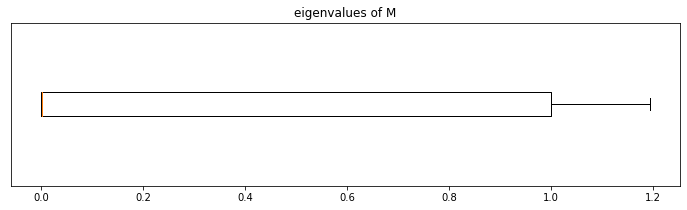

In [153]:
f, axarr = plt.subplots(1, 1, figsize=(12, 3))
axarr.boxplot(evals, vert=False);
axarr.set_yticks([]);
axarr.set_title('eigenvalues of M'); 

In [154]:
cg_callback = CGCallback(mat_times_vec, b)
solver = vittles.solver_lib.get_cg_solver(mat_times_vec, 
                                            dim = len(vb_opt), 
                                            cg_opts={'M':nystrom_precond3, 
                                                     'callback':cg_callback.record_residuals, 
                                                    'x0':x0})
    
t0 = time.time()
_ = -solver(b)
print('solver time: {:0.3}sec'.format(time.time() - t0))
path5 = cg_callback.return_path()

solver time: 4.87sec


Text(0, 0.5, 'log10 residual')

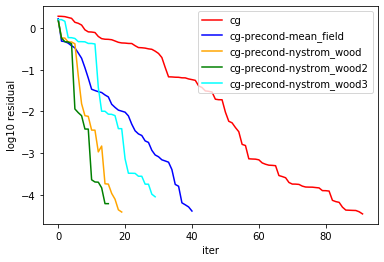

In [155]:
plt.plot(np.log10(path1), color = 'red', label = 'cg')
plt.plot(np.log10(path2), color = 'blue', label = 'cg-precond-mean_field')
plt.plot(np.log10(path3), color = 'orange', label = 'cg-precond-nystrom_wood')
plt.plot(np.log10(path4), color = 'green', label = 'cg-precond-nystrom_wood2')
plt.plot(np.log10(path5), color = 'cyan', label = 'cg-precond-nystrom_wood3')

plt.legend()

plt.xlabel('iter')
plt.ylabel('log10 residual')